<h1>Part 1: Preprocessing the Data</h1>

In [71]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

In [72]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [73]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [74]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


In [75]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [76]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [77]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

for dataset in combine:
    dataset_copy = dataset.copy()

    features = ['Sex', 'Pclass','SibSp','Parch','Title']
    target = 'Age'

    missing_data = dataset_copy[dataset_copy[target].isnull()]
    no_missing_data = dataset_copy.dropna(subset=[target])

    if not missing_data.empty:
        imputer = SimpleImputer(strategy='mean')
        regressor = RandomForestRegressor()
        regressor.fit(no_missing_data[features], no_missing_data[target])
        imputed_values = regressor.predict(missing_data[features])
        dataset.loc[dataset[target].isnull(), target] = imputed_values

    dataset['Age'] = dataset['Age'].astype(int)

In [78]:
freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [79]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

for dataset in combine:
    dataset['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [80]:
X_train = train_df.drop(['Name', 'PassengerId','Survived'], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(['Name','PassengerId'], axis=1).copy()

<h1>Part 2: Fine-Tune a Decision Tree</h1>

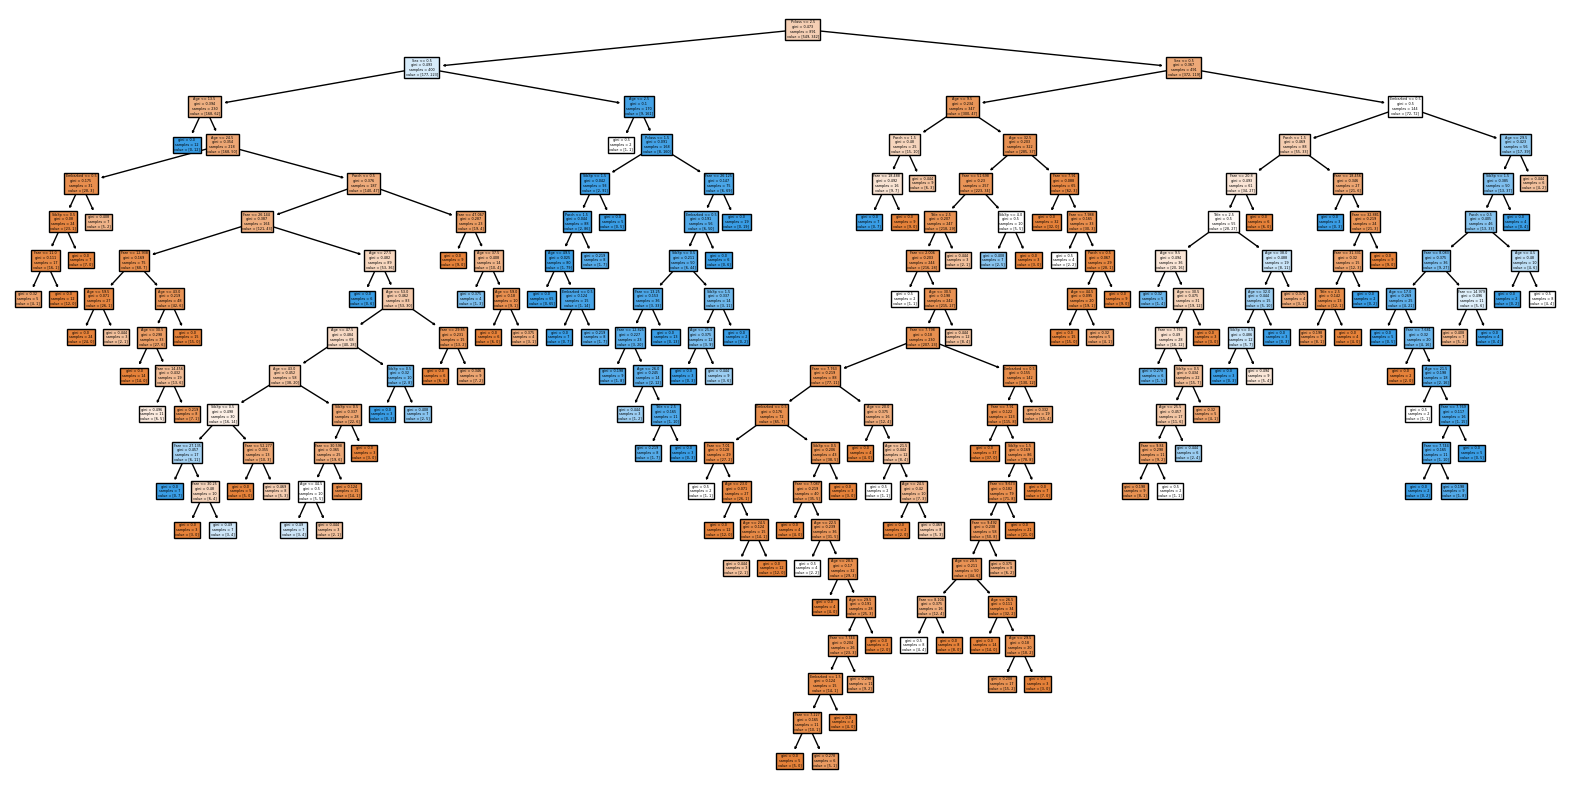

In [81]:
np.random.seed(40)
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_decision_tree = DecisionTreeClassifier(**best_params)
best_decision_tree.fit(X_train, Y_train)
Y_pred = best_decision_tree.predict(X_test)

acc_decision_tree = round(best_decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

plt.figure(figsize=(20,10))
plot_tree(best_decision_tree, filled=True, feature_names=list(X_train.columns))
plt.show()


<h1>Part 3: Fine-Tune a Decision Tree with 5-fold CV</h1>

In [82]:
np.random.seed(40)
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [83]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [84]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_decision_tree = DecisionTreeClassifier(**best_params)
best_decision_tree.fit(X_train, Y_train)
Y_pred = best_decision_tree.predict(X_test)

In [85]:
acc_decision_tree = round(best_decision_tree.score(X_train, Y_train) * 100, 2)

print("Best Parameters:", best_params)
print("Best Score (Mean Cross-Validated Accuracy):", best_score)
print("Training Accuracy with Best Parameters:", acc_decision_tree)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Score (Mean Cross-Validated Accuracy): 0.8170610758897746
Training Accuracy with Best Parameters: 87.65


<h1>Part 4: Fine-Tune a Random Forest with 5-fold CV</h1>

In [86]:
np.random.seed(40)
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [87]:
cv_rf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=cv_rf, n_jobs=-1)
grid_search_rf.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]})

In [88]:
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
best_random_forest = RandomForestClassifier(**best_params_rf)
best_random_forest.fit(X_train, Y_train)
Y_pred_rf = best_random_forest.predict(X_test)

In [89]:
acc_random_forest = round(best_random_forest.score(X_train, Y_train) * 100, 2)

print("Best Parameters for Random Forest:", best_params_rf)
print("Best Score (Mean Cross-Validated Accuracy) for Random Forest:", best_score_rf)
print("Training Accuracy with Best Parameters for Random Forest:", acc_random_forest)

Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best Score (Mean Cross-Validated Accuracy) for Random Forest: 0.8440085368150146
Training Accuracy with Best Parameters for Random Forest: 88.22


<h1>Part 5: Model Comparision</h1>

In [90]:
models = ['Decision Tree', 'Random Forest']
best_scores = [best_score * 100, best_score_rf * 100]
training_accuracies = [acc_decision_tree, acc_random_forest]

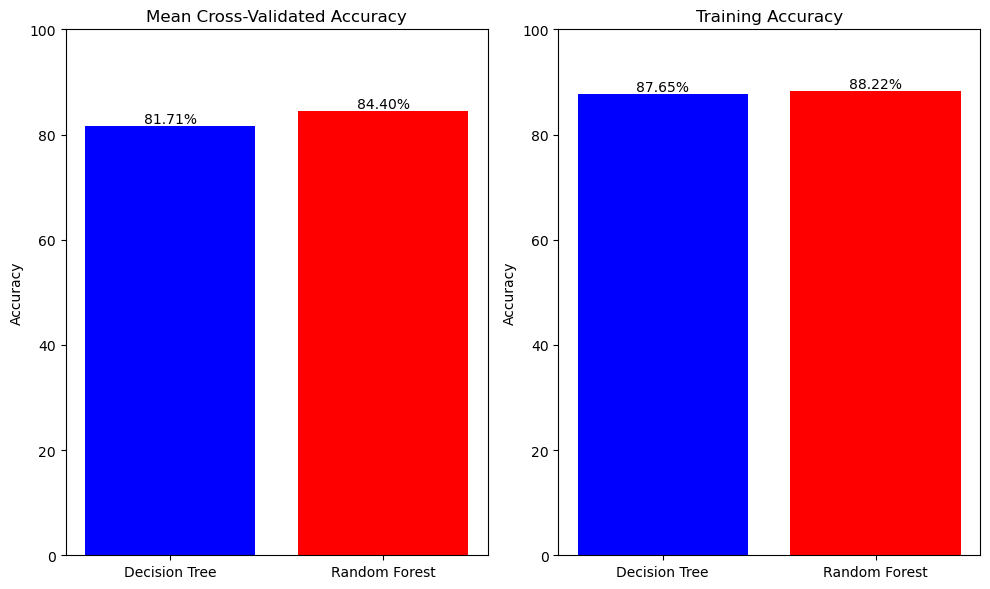

In [91]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(models, best_scores, color=['blue', 'red'])
plt.title('Mean Cross-Validated Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.0, 100.0)
for bar, score in zip(bars, best_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}%', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(models, training_accuracies, color=['blue', 'red'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.0, 100.0)
for bar, accuracy in zip(bars, training_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}%', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()